In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import warnings
%matplotlib  inline
warnings.simplefilter('ignore')



## Подход #1: градиентный бустинг "в лоб"

В отчете по данному этапу необходимо ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

###  Первый взгляд на датасет
Загрузим датасет и посмотрим на признаки. 
Загружаем файл с данными о матчах...

In [2]:
Xcsv = pd.read_csv('features.csv', index_col='match_id')
Xcsv_test = pd.read_csv('features_test.csv', index_col='match_id')

... и проверяем какие признаки содержат пропущенные данные

In [3]:
rows = Xcsv.shape[0]
for col in Xcsv.columns:
    if Xcsv[col].count() < rows:
        skip = rows - Xcsv[col].count()
        print(f'Признак \'{col}\' имеет {skip} пропущенных значений - ({100 * skip / rows: 0.2f} % )')
        

Признак 'first_blood_time' имеет 19553 пропущенных значений - ( 20.11 % )
Признак 'first_blood_team' имеет 19553 пропущенных значений - ( 20.11 % )
Признак 'first_blood_player1' имеет 19553 пропущенных значений - ( 20.11 % )
Признак 'first_blood_player2' имеет 43987 пропущенных значений - ( 45.24 % )
Признак 'radiant_bottle_time' имеет 15691 пропущенных значений - ( 16.14 % )
Признак 'radiant_courier_time' имеет 692 пропущенных значений - ( 0.71 % )
Признак 'radiant_flying_courier_time' имеет 27479 пропущенных значений - ( 28.26 % )
Признак 'radiant_first_ward_time' имеет 1836 пропущенных значений - ( 1.89 % )
Признак 'dire_bottle_time' имеет 16143 пропущенных значений - ( 16.60 % )
Признак 'dire_courier_time' имеет 676 пропущенных значений - ( 0.70 % )
Признак 'dire_flying_courier_time' имеет 26098 пропущенных значений - ( 26.84 % )
Признак 'dire_first_ward_time' имеет 1826 пропущенных значений - ( 1.88 % )


Признаки с постфиксом '_time' относятся к временным меткам и означают, что за первые пять минут матча соответствующее событие не произошло. В задании рекомендуется заменить такие значения на 0, но такая рекомендация в данном случае не вполне подходит. Правильнее было бы заменить эти значения, на время превосходящее или равное пяти минутам. 
Признаки first_blood_player1 и first_blood_player2 указывают на номер игрока в текущем матче. Пропущенные значения у них означают, что за первые пять минут соответстующее им событие не произошло. Следует отметить, что признак first_blood_player2 имеет более 40 % пропущенных значений и хорошего прогноза по нему не построить. Предлагается исключить его из тестовой выборки.
мазаменим на медианные значения по признаку. Затем проверим, что у нас больше не осталось пропущенных данных.

**Целевая переменная содержится в столбце 'radiant_win'.** Создадим из него объект ответов Y и удалим из обучающей выборки его, а также признаки, связанные с итогами матча.

In [4]:
X = Xcsv[::]
X['first_blood_player1'].fillna(np.random.randint(10), inplace=True)
#X['first_blood_player2'].fillna(np.random.randint(10), inplace=True)
X.fillna(300, inplace=True)
y = X['radiant_win']
X.drop(['radiant_win',
        'duration',
        'tower_status_radiant', 
        'tower_status_dire', 
        'barracks_status_dire', 
        'barracks_status_radiant', 
        'start_time', 
        'first_blood_player2' ],
       axis=1, inplace=True)

rows = X.shape[0]
for col in X.columns:
    if X[col].count() < rows:
        print(f'Признак {col} содержит {rows - Xcsv[col].count()} пропущенных значений')
print(f'Xcsv.shape is {Xcsv.shape}')
print(f'X.shape is {X.shape}')

Xcsv.shape is (97230, 108)
X.shape is (97230, 100)


In [5]:
X.shape, y.shape

((97230, 100), (97230,))

### Бустинг

Проведём сначала решётчатый поиск на градиентном бустинге для определения оптимальных параметров. Зададимся количеством деревьев равным 30 и найдём наилучшие значения для глубины деревьев и скорости обучения.

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state = 241 )
params = {
    'learning_rate': np.linspace(0.2, 0.4, 5),
    'max_depth': np.linspace(4, 6, 3, dtype=np.int8),
    'n_estimators': np.linspace(10, 30, 3, dtype=np.int8)}
print(*params.items(), sep='\n')
clf = GradientBoostingClassifier(random_state=241, n_estimators=30)           

('learning_rate', array([0.2 , 0.25, 0.3 , 0.35, 0.4 ]))
('max_depth', array([4, 5, 6], dtype=int8))
('n_estimators', array([10, 20, 30], dtype=int8))


In [7]:
grid = GridSearchCV(clf, params, cv=cv, n_jobs=-1, scoring='roc_auc', verbose=True)

In [8]:
%%time
grid.fit(X, y);

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 53.6min finished


CPU times: user 1min 16s, sys: 760 ms, total: 1min 16s
Wall time: 54min 26s


GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=241, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': array([0.2 , 0.25, 0.3 , 0.35, 0.4 ]), 'max_depth': array([4, 5, 6], dtype=int8), 'n_estimators': array([10, 20, 30], dtype=int8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [9]:
print(f"Наилучшие значения параметров: {grid.best_params_}, наилучший результат на кросс-валидации: {grid.best_score_:.5f}")

Наилучшие значения параметров: {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 30}, наилучший результат на кросс-валидации: 0.70379


Проведём кросс-валидацию на полной выборке с наилучшими значениями <i>'learning_rate'</i> и <i>'max_depth'</i>, полученными в предыдущем пункте с количеством деревьев равным 30. Измерим время кросс-валидации.

In [12]:
clf = GradientBoostingClassifier(learning_rate=grid.best_params_['learning_rate'],
                                 max_depth=grid.best_params_['max_depth'] ,
                                 n_estimators=30,
                                 random_state=241)

In [13]:
%time crossval_scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
print(f'Качество на кросс-валидации составляет {crossval_scores.mean():0.5f}')

CPU times: user 3min, sys: 450 ms, total: 3min
Wall time: 3min
Качество на кросс-валидации составляет 0.70379


Время кросс-валидации составило  3min 17s, качество - 0.70379

Для того чтобы ответить на вопрос - имеет ли смысл  использовать больше 30 деревьев в градиентном бустинге, проверим как будет вести себя ансамбль с количеством деревьев до тысячи.

__________
##########
Наилучший результат - 0.72608,
количество деревьев - 900
CPU times: user 31min 56s, sys: 499 ms, total: 31min 56s
Wall time: 31min 56s


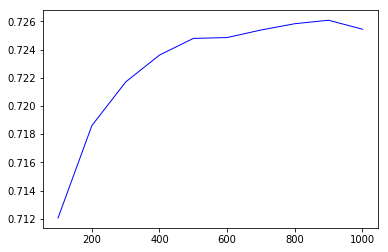

In [15]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 241 )
n_trees = np.linspace(100, 1000, 10, dtype=np.int)
#plt.figure()
roc = []
print('_'*10)
max_score = 0,0
for n in n_trees:
    clf = GradientBoostingClassifier(
        max_depth=2, n_estimators=n,random_state=241,
        learning_rate=0.225).fit(X_train, y_train)
    pred = clf.predict_proba(X_test)[:, 1]
    roc_score = roc_auc_score(y_test, pred)
    roc.append(roc_score)
    if roc_score > max_score[0]:
        max_score = roc_score, n
    if n % 100 == 0:
        print('#', end='')
plt.plot(n_trees, roc, 'b', linewidth=1)
print(f"""
Наилучший результат - {max_score[0]:.5f},
количество деревьев - {max_score[1]}""")


С увеличением количества деревьев прирост качества становится незначительным, а время вычисления растёт.

## Подход #2: логистическая регрессия

Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?<br/>
Найдём при помощи решетчатого поиска оптимальный параметр С и проведём кросс-валидацию. Для масштабирования на решетчатом поиске воспользуемся конвеером при помощи функции make_pipeline.

In [16]:
Xcsv_train = pd.read_csv('features.csv', index_col='match_id')
Xcsv_test = pd.read_csv('features_test.csv', index_col='match_id')
y = Xcsv_train['radiant_win']

Обработка пропущенных значений

In [17]:
np.random.seed(17)

Xcsv_train['first_blood_player1'].fillna(np.random.randint(10), inplace=True)
Xcsv_train['first_blood_player2'].fillna(np.random.randint(10), inplace=True)
Xcsv_train.fillna(300, inplace=True)

Xcsv_test['first_blood_player1'].fillna(np.random.randint(10), inplace=True)
Xcsv_test['first_blood_player2'].fillna(np.random.randint(10), inplace=True)
Xcsv_test.fillna(300, inplace=True)


### Линейная регрессия "в лоб"
Попробуем подать данные в регрессию  как есть и проведём кросс-валидацию.

In [18]:
X = Xcsv_train.drop(['radiant_win',
        'duration',
        'tower_status_radiant', 
        'tower_status_dire', 
        'barracks_status_dire', 
        'barracks_status_radiant', 
        'start_time', 
        'first_blood_player2' ],
       axis=1) #  + players


In [20]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=17))#
param_grid = {'logisticregression__C': np.logspace(0, 2, 10)}
%time grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1).fit(X, y)

C = grid.best_params_['logisticregression__C']
print(f'Значение С при лучшем результате равно {C}')


CPU times: user 12.6 s, sys: 469 ms, total: 13.1 s
Wall time: 1min 45s
Значение С при лучшем результате равно 1.0


In [21]:
pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=17, C=C))
%time crossval_scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')
print(f'Лучшее качество на кросс-валидации равно {crossval_scores.mean():.4f}')

CPU times: user 38.8 s, sys: 1.11 s, total: 39.9 s
Wall time: 33.3 s
Лучшее качество на кросс-валидации равно 0.7167


Теперь дропнем столбцы lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero

In [22]:
radcol = ['r%i_hero' %i for i in range(1,6)]
direcol = ['d%i_hero' %i for i in range(1,6)]
players = radcol + direcol
X.drop(players + ['lobby_type'], axis=1, inplace=True)

In [23]:
pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=17))#
param_grid = {'logisticregression__C': np.logspace(0, 2, 10)}
%time grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1).fit(X, y)

C = grid.best_params_['logisticregression__C']
print(f'Значение С при лучшем результате равно {C}')


CPU times: user 12.9 s, sys: 478 ms, total: 13.4 s
Wall time: 2min 8s
Значение С при лучшем результате равно 1.0


In [24]:
pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=17, C=C))
%time crossval_scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')
print(f'Лучшее качество на кросс-валидации равно {crossval_scores.mean():.4f}')

CPU times: user 33.1 s, sys: 989 ms, total: 34.1 s
Wall time: 27.8 s
Лучшее качество на кросс-валидации равно 0.7167


Качество на кросс-валидации не изменилось. Удаление категориальных признаков не повлияло на качество регрессии. Это можно объяснить тем, что линейная регрессия неспособна работать с категориальными признаками, и в таком виде информация об игроках для линейной регрессии является шумом.
Логистическая регрессия хорошо подходит для решения задач классификации с линейно-разделяемыми классами, но требует правильной подготовки данных для обучения.

### Мешок слов
Посчитаем количество уникальных героев.


In [25]:
max_id = Xcsv_train[players].values.max()
print(f'Максимальный id - {max_id}')
for i in range(1, max_id+1):
    if i not in Xcsv_train[players].values:
        max_id -= 1
        print(f'{i} отсутствует в списке')
print(f'Всего {max_id} различных героев')

Максимальный id - 112
24 отсутствует в списке
107 отсутствует в списке
108 отсутствует в списке
111 отсутствует в списке
Всего 108 различных героев


Теперь посмотрим на признаки, которые у нас есть.

In [26]:
[print(column, end=' ') for column in Xcsv_train.columns if not column.startswith('d')];

start_time lobby_type r1_hero r1_level r1_xp r1_gold r1_lh r1_kills r1_deaths r1_items r2_hero r2_level r2_xp r2_gold r2_lh r2_kills r2_deaths r2_items r3_hero r3_level r3_xp r3_gold r3_lh r3_kills r3_deaths r3_items r4_hero r4_level r4_xp r4_gold r4_lh r4_kills r4_deaths r4_items r5_hero r5_level r5_xp r5_gold r5_lh r5_kills r5_deaths r5_items first_blood_time first_blood_team first_blood_player1 first_blood_player2 radiant_bottle_time radiant_courier_time radiant_flying_courier_time radiant_tpscroll_count radiant_boots_count radiant_ward_observer_count radiant_ward_sentry_count radiant_first_ward_time radiant_win tower_status_radiant tower_status_dire barracks_status_radiant barracks_status_dire 

Признаки r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero являются категориальными и содержат информацию о реальных id героев. По этим признакам будем строить мешок слов.
Признаки относящиеся к первой крови можно не гляда дропнуть, с ними только хуже. Поверьте, я проверял! Сформируем из героев "мешок слов". Воспользуемся для этого классом CountVectorizer.

In [27]:
# Датафреймы с игроками каждой команды для тренировочной и тестовой выборок
radiant = Xcsv_train[radcol]
dire = Xcsv_train[direcol]
radiant_test = Xcsv_test[radcol]
dire_test = Xcsv_test[direcol]

In [28]:
# Сливаем датафреймы в файлы, чтобы скормить их в CountVectorizer
radiant.to_csv('train_radiant_text.txt',  sep=' ', index=None, header=None)
dire.to_csv('train_dire_text.txt',  sep=' ', index=None, header=None)
radiant_test.to_csv('test_radiant_text.txt',  sep=' ', index=None, header=None)
dire_test.to_csv('test_dire_text.txt',  sep=' ', index=None, header=None)

In [29]:
!cat train_radiant_text.txt > train_text.txt 
!cat train_dire_text.txt >> train_text.txt 

In [30]:
cvr = CountVectorizer(analyzer='word',
                      token_pattern=u"(?u)\\b\\w+\\b") #
with open('train_text.txt') as train, \
open('train_radiant_text.txt') as radiant_train, \
open('train_dire_text.txt') as dire_train, \
open('test_radiant_text.txt') as radiant_test, \
open('test_dire_text.txt') as dire_test:
    cvr.fit(train)
    X_rad_train = cvr.transform(radiant_train)
    X_dire_train = cvr.transform(dire_train)
    X_rad_test = cvr.transform(radiant_test)
    X_dire_test = cvr.transform(dire_test)

In [31]:
X_train_sparse = X_rad_train - X_dire_train
X_test_sparse = X_rad_test - X_dire_test

In [32]:
#Признаки, которые будут удалены из выборки
drop_col_test = radcol + direcol + ['start_time',
                                    'lobby_type', 
                                    'first_blood_time',
                                    'first_blood_team', 
                                    'first_blood_player2',] 
drop_col = drop_col_test + ['radiant_win',
                            'duration',
                            'tower_status_radiant', 
                            'tower_status_dire', 
                            'barracks_status_dire', 
                            'barracks_status_radiant']

In [33]:
Xd_train = Xcsv_train.drop(drop_col, axis=1)
Xd_test = Xcsv_test.drop(drop_col_test, axis=1)

In [34]:
X = (hstack([X_train_sparse, Xd_train])).toarray()
X_test = hstack([X_test_sparse, Xd_test]).toarray()

In [35]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=17))#
param_grid = {'logisticregression__C': np.logspace(-3, -2, 5)}
#param_grid = {'logisticregression__C': np.linspace(0.004, 0.009, 6)}
param_grid['logisticregression__C']

array([0.001     , 0.00177828, 0.00316228, 0.00562341, 0.01      ])

In [36]:
cv = KFold(n_splits=5, shuffle=True, random_state=17)
grid = GridSearchCV(pipe,
                    param_grid=param_grid, 
                    scoring='roc_auc',
                    cv=cv, n_jobs=-1,
                    verbose=False)

In [37]:
grid.fit(X, y);

In [38]:
grid.best_score_, grid.best_params_['logisticregression__C']

(0.7522609327229591, 0.005623413251903491)

In [39]:
C = grid.best_params_['logisticregression__C']
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=17, C=C))#

In [40]:
%time crossval_scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')
print(f'Качество на кросс-валидации равно {crossval_scores.mean():.5f}')

CPU times: user 45 s, sys: 1.91 s, total: 46.9 s
Wall time: 35.7 s
Качество на кросс-валидации равно 0.75226


In [41]:
def write_to_submission_file(predicted_labels, index, out_file,
                             target='radiant_win', index_label="match_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = index,
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [42]:
logreg = LogisticRegression(random_state=17,
                            C=grid.best_params_['logisticregression__C']).fit(X, y)
y_sub = logreg.predict_proba(X_test)
write_to_submission_file(predicted_labels=y_sub[:,1], out_file='BoW.csv', index=Xcsv_test.index)

In [43]:
C = grid.best_params_['logisticregression__C']
message = f'"Мешок слов, логистическая регрессия C = {C:.4f}"'
!kaggle competitions submit -c dota-2-win-probability-prediction -f BoW.csv -m {message}

Successfully submitted to Dota 2: Win Probability Prediction

Результат на Kaggle - 0.75555

### Как улучшить?
Можно попробовать, например, следующий подход. У класса CountVectorizer есть параметры
ngram_range и max_feature, с помощью который можно получить информацию о взаимных сочетания различных героев. Такой подход не позволяет получить информацию о всех возможных сочетаниях, но тем не менее полученные сведения позволять улучшить результат. Сначала необходимо для каждого матча в каждой команде упорядочить игроков по id. Это нужно для того, чтобы исключить дублирования одинаковых сочетаний, например (2,3) и (3, 2) или (1, 3, 6), (1, 6, 3)и  (6, 1, 3) и т.д. Параметр ngram_range позволяет задавать размерность сочетаний (зададим их от одного до пяти), max_feature ограничивает число комбинаций, оставляя наиболее значимы. В противном случае нас ждёт комбинаторный взрыв. Ведь число сочетаний из 108 по 2 составляет 5778, а из 108 по 5 уже 111469176. Эмпирически установлено, что наилучший результат получается при max_feature=40000

In [44]:
radiant = Xcsv_train[radcol]
dire = Xcsv_train[direcol]
radiant_test = Xcsv_test[radcol]
dire_test = Xcsv_test[direcol]

In [45]:
# сортируем героев в командах по ранжиру
rad_sort = pd.DataFrame(data=0, index=radiant.index, columns=radcol)
rad_sort = radiant.apply(lambda x: pd.Series(np.sort(x), index=x.index), axis=1) 
dire_sort = pd.DataFrame(data=0, index=radiant.index, columns=direcol)
dire_sort = dire.apply(lambda x: pd.Series(np.sort(x), index=x.index), axis=1) 
rad_sort_test = pd.DataFrame(data=0, index=radiant_test.index, columns=radcol)
rad_sort_test = radiant_test.apply(lambda x: pd.Series(np.sort(x), index=x.index), axis=1) 
dire_sort_test = pd.DataFrame(data=0, index=dire_test.index, columns=direcol)
dire_sort_test = dire_test.apply(lambda x: pd.Series(np.sort(x), index=x.index), axis=1) 

In [46]:
rad_sort.to_csv('train_radiant_text.txt',  sep=' ', index=None, header=None)
dire_sort.to_csv('train_dire_text.txt',  sep=' ', index=None, header=None)
rad_sort_test.to_csv('test_radiant_text.txt',  sep=' ', index=None, header=None)
dire_sort_test.to_csv('test_dire_text.txt',  sep=' ', index=None, header=None)


In [47]:
!cat train_radiant_text.txt > train_text.txt 
!cat train_dire_text.txt >> train_text.txt 

In [48]:
max_features = 40000
cvr = CountVectorizer(analyzer='word',
                      ngram_range=(1, 5),
                      max_features=max_features,
                      token_pattern=u"(?u)\\b\\w+\\b") #
with open('train_text.txt') as train, \
open('train_radiant_text.txt') as radiant_train, \
open('train_dire_text.txt') as dire_train, \
open('test_radiant_text.txt') as radiant_test, \
open('test_dire_text.txt') as dire_test:
    cvr.fit(train)
    X_rad_train = cvr.transform(radiant_train)
    X_dire_train = cvr.transform(dire_train)
    X_rad_test = cvr.transform(radiant_test)
    X_dire_test = cvr.transform(dire_test)

In [49]:
X_train_sparse = X_rad_train - X_dire_train
X_test_sparse = X_rad_test - X_dire_test

In [50]:
drop_col_test = [col for col in Xcsv_test.columns if '_hero' in col] + \
['start_time', 'first_blood_player1', 'first_blood_player2', 'lobby_type', 
'first_blood_time']
drop_col = drop_col_test + ['radiant_win',
        'duration',
        'tower_status_radiant', 
        'tower_status_dire', 
        'barracks_status_dire', 
        'barracks_status_radiant']

In [51]:
Xd_train = Xcsv_train.drop(drop_col, axis=1)
Xd_test = Xcsv_test.drop(drop_col_test, axis=1)

In [53]:
scaler = StandardScaler()
scaler.fit(Xd_train)
Xs_train = scaler.transform(Xd_train)
Xs_test = scaler.transform(Xd_test)

Здесь пришлось сделать грязный трюк - сначала нормализовать датафрейм с данными, а потом соединять получившийся результат с результатом выхода CountVectorizer. Но из всех скалеров с разреженными матрицами нормально работать может тольк MaxAbsScaler, а с ним результат получался чуть хуже.

In [54]:
X_train_sparse = hstack([X_train_sparse, Xs_train])
X_test_sparse = hstack([X_test_sparse, Xs_test])

In [55]:
#param_grid = {'C': np.logspace(-3, 0, 7)}
param_grid = {'C': np.linspace(0.003, 0.03,10)}
param_grid['C']

array([0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.021, 0.024, 0.027,
       0.03 ])

In [56]:
cv = KFold(n_splits=5, shuffle=True, random_state=17)
grid = GridSearchCV(LogisticRegression(random_state=17),
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=cv, n_jobs=-1)

In [57]:
%time grid.fit(X_train_sparse, y);

CPU times: user 49.5 s, sys: 810 ms, total: 50.3 s
Wall time: 9min 6s


GridSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.021, 0.024, 0.027,
       0.03 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [58]:
grid.best_score_, grid.best_params_ 

(0.7520999922813807, {'C': 0.006})

In [59]:
# Обучаем регрессию с лучшим получившимся параметром C
logreg = LogisticRegression(random_state=17, **grid.best_params_).fit(X_train_sparse, y)

In [60]:
y_sub = logreg.predict_proba(X_test_sparse)
write_to_submission_file(predicted_labels=y_sub[:,1], out_file='WoB.csv', index=Xcsv_test.index)

In [67]:
print(f'Минимальное значение прогноза на тестовой выборке равно {y_sub.min():0.5f}')
print(f'Максимальное значение прогноза на тестовой выборке равно {y_sub.max():0.5f}')

Минимальное значение прогноза на тестовой выборке равно 0.00384
Максимальное значение прогноза на тестовой выборке равно 0.99616


In [62]:
C = grid.best_params_['C']
message = f'"CountVectorizer, {max_features} n-gramms, суммы признаков, логистическая регрессия  C = {C:.4f}"'
!kaggle competitions submit -c dota-2-win-probability-prediction -f WoB.csv -m {message}

Successfully submitted to Dota 2: Win Probability Prediction

### Результат на Kaggle - 0.75772